## Modules à importer

In [122]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from scipy.optimize import fsolve
from variaIa.variaIa import baserate
from scipy.interpolate import interp1d
from variaIa.variaIa import stretchevol
from variaIa.variaIa import ratefitnb
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [126]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

with open('../Data/zmax_spec_result', 'rb') as f:
    dict_zmax= pickle.load(f)[-2]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    if su == 'PS1':
        dataz = np.sort(surv[su].zCMB.values[np.where(surv[su].zCMB.values > .1)])
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

## Plot tentative

In [150]:
reload(ratefitnb)

a_guess = 0.4
zmax_guess = .7

test = ratefitnb.RateFit()
test.set_data(dataz, su.value)
#test.set_param([1, .28])
test.minimize(a = a_guess, zmax = zmax_guess,
              limit_a=(0.12, 2), limit_zmax=(0.4, 0.8))

{'a': 0.2026, 'zmax': 0.6089}
Logprob =  0.8674814264484136


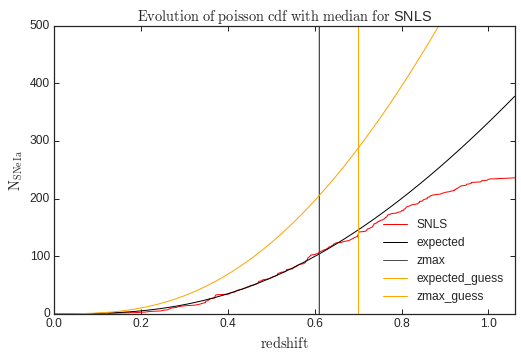

In [151]:
reload(ratefitnb)

test.plot([a_guess, zmax_guess])
print(test.param)
print('Logprob = ', test.get_logprob(test.param['a'], test.param['zmax']))

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/zmax_nobins_'
#            + su.value
#            + '_a_'
#            + str(test.param['a'])
#            + '_z_'
#            + str(test.param['zmax'])
#            + '.pdf')

## Hand-fitting

In [139]:
reload(ratefitnb)

a = ipw.FloatSlider(min = .05, max = 10,
                    value = 0.20, step=.001,
                    description='a value:',
                    continuous_update=False)

zmax = ipw.FloatSlider(min = .1, max = .70,
                       value = .610, step=.001,
                       description='zmax value:',
                       continuous_update=False)

def int_get_aicc(a, zmax):
    print('Log L = ', test.get_loglikelihood(a, zmax))
    print('Log L/DoF = ', test.get_loglikeDOF(a, zmax))
    print('AICc = ', test.get_aicc(a, zmax))
    print('AICc/DoF = ', test.get_aiccDOF(a, zmax))
    print('Logprob = ', test.get_logprob(a, zmax))

    fig = plt.figure(figsize=[8, 5])
    ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

    zz = np.linspace(0, np.max(test.data))
    
    ax.plot(test.data,
            test.counts,
            color=colors[su.value],
            lw=1.0, label=su.value)

    ax.plot(zz,
            test.get_ratemodel(zz, a),
            color='black',
            lw=1.0, label='expected')
    
    ax.plot(zz,
            test.get_ratemodel(zz, test.param['a']),
            color='red',
            lw=1.0, label='expected_found')

    ax.vline(zmax,
             color=".3",
             lw=1.0, label="zmax")
    
    ax.vline(test.param['zmax'],
             color="red",
             lw=1.0, label="zmax_found")
    
    ax.tick_params(direction='in',
                   length=5, width=1,
                   labelsize=12,
                   top=True, right=True)

    ax.set_xlim(0, np.max(test.data))
    ax.set_ylim(0, 500)

    ax.set_xlabel(r'$\mathrm{redshift}$', fontsize='x-large')
    ax.set_ylabel(r'$\mathrm{N}_\mathrm{SNe\,Ia}$', fontsize='x-large')

    plt.legend(ncol=1, loc='lower right')

    plt.title(r'$\mathrm{Evolution\,\,of\,\,poisson\,\,cdf\,\,with\,\,}$' +
              r'$\mathrm{median\,\,for\,\,surveys}$',
              fontsize='x-large')
    
    fig=plt.gcf()
#    fig.savefig('/home/nora/Documents/Thèse/Images/zmax_nobins_hand_'
#                + su.value
#                + '_a_'
#                + str(a)
#                + '_z_'
#                + str(zmax)
#                + '.pdf')

inter_aicc = ipw.interactive(int_get_aicc, a=a, zmax=zmax)

display(inter_aicc)

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='a value:', max=10.0, min=0.…